In [1]:
# https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"theobervanakis","key":"74de48417bd53eae60e2b46c03500945"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
import os
import zipfile
import kaggle

In [4]:
# Download dataset from Kaggle
if not os.path.exists('dataset/instacart-market-basket-analysis.zip'):
    os.system('kaggle competitions download -c instacart-market-basket-analysis -p dataset/')

# Unzip download
ZIPFILE_PATH = os.path.join('dataset', 'instacart-market-basket-analysis.zip')

with zipfile.ZipFile(ZIPFILE_PATH, 'r') as main_zipfile:
    main_zipfile.extractall(path=os.path.join('dataset', 'zip'))

# Unzip all wanted csv files
EXTRACTED_ZIPFILES_DIRECTORY = os.path.join('dataset', 'zip')

for filename in os.listdir(EXTRACTED_ZIPFILES_DIRECTORY):
    individual_zipfile_path = os.path.join(EXTRACTED_ZIPFILES_DIRECTORY, filename)
    if filename.endswith('.zip') and filename != 'sample_submission.csv.zip':
        with zipfile.ZipFile(individual_zipfile_path, 'r') as individual_zipfile:
            individual_zipfile.extractall(path=os.path.join('dataset', 'csv'))

os.remove(ZIPFILE_PATH)

In [5]:
# Spark is written in Scala. Soo we will require a Java Virtual Machine (JVM) to run it.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#  install Apache Spark 3.0.1 with Hadoop 2.7
!wget -P /content/drive/MyDrive/PySpark https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
# unzip
!tar xf /content/drive/MyDrive/PySpark/spark-3.4.0-bin-hadoop3.tgz

# Set the environment path
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"

--2023-06-26 11:48:53--  https://dlcdn.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388407094 (370M) [application/x-gzip]
Saving to: ‘/content/drive/MyDrive/PySpark/spark-3.4.0-bin-hadoop3.tgz.6’

spark-3.4.0-bin-had 100%[===================>] 370.41M  36.1MB/s    in 9.0s    

2023-06-26 11:49:02 (41.3 MB/s) - ‘/content/drive/MyDrive/PySpark/spark-3.4.0-bin-hadoop3.tgz.6’ saved [388407094/388407094]



In [6]:
!pip install -q findspark
!pip install pyspark
import findspark
findspark.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Import SparkSession from pyspark.sql and create a SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("instacart_market_basket_analysis")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [8]:
spark

In [9]:
!pip install pyngrok
from pyngrok import ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# Setup Spark UI
# Setting the authtoken
ngrok.kill()
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTP tunnel on port 4050
public_url = ngrok.connect(4050)
print("Your Spark UI is exposed at:", public_url)

Your Spark UI is exposed at: NgrokTunnel: "https://0f1e-34-86-49-63.ngrok-free.app" -> "http://localhost:4050"


In [11]:
# Read the CSV data
orders = spark.read.csv('dataset/csv/orders.csv', header=True, inferSchema=True)
order_products_prior = spark.read.csv('dataset/csv/order_products__prior.csv', header=True, inferSchema=True)
products = spark.read.csv('dataset/csv/products.csv', header=True, inferSchema=True)
aisles = spark.read.csv('dataset/csv/aisles.csv', header=True, inferSchema=True)
departments = spark.read.csv('dataset/csv/departments.csv', header=True, inferSchema=True)


# Join the data
data = orders.join(order_products_prior, "order_id")\
             .join(products, "product_id")\
             .join(aisles, "aisle_id")\
             .join(departments, 'department_id')\


data.show()

+-------------+--------+----------+--------+-------+--------+------------+---------+-----------------+----------------------+-----------------+---------+--------------------+--------------------+------------+
|department_id|aisle_id|product_id|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|add_to_cart_order|reordered|        product_name|               aisle|  department|
+-------------+--------+----------+--------+-------+--------+------------+---------+-----------------+----------------------+-----------------+---------+--------------------+--------------------+------------+
|           16|      53|     30597|      12| 152610|   prior|          22|        6|                8|                  10.0|                1|        1|French Vanilla Co...|               cream|  dairy eggs|
|           16|      84|     15221|      12| 152610|   prior|          22|        6|                8|                  10.0|                2|        1|           

In [12]:
data.printSchema()

root
 |-- department_id: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)



In [13]:
from pyspark.sql.functions import split, collect_list, col, count

# Group by 'order_id' and collect the 'product_name's for each order
transactions = data.groupBy('order_id').agg(collect_list('product_name').alias('items'))

# Show the result
transactions.show(truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                                                                                                                                                                                                                                                  

In [21]:
from pyspark.ml.fpm import FPGrowth

# Initialize the FPGrowth algorithm
fpGrowth = FPGrowth(itemsCol='items', minSupport=0.005, minConfidence=0.10)

# Fit the model
model = fpGrowth.fit(transactions)

# Display frequent itemsets
model.freqItemsets.show(truncate=False)

# Display generated association rulesd
model.associationRules.show(truncate=False)

# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(transactions).show(truncate=False)

+------------------------------------------------+------+
|items                                           |freq  |
+------------------------------------------------+------+
|[Original No Pulp 100% Florida Orange Juice]    |19345 |
|[Baby Spinach]                                  |23129 |
|[Lemon Hummus]                                  |16439 |
|[Sharp Cheddar Cheese]                          |30170 |
|[Unsweetened Original Almond Breeze Almond Milk]|34583 |
|[Oven Roasted Turkey Breast]                    |20069 |
|[Green Bell Pepper]                             |55484 |
|[Yellow Bell Pepper]                            |25459 |
|[Organic Small Bunch Celery]                    |68091 |
|[Organic Red Radish, Bunch]                     |27226 |
|[Organic Broccoli]                              |38720 |
|[Seedless Red Grapes]                           |82689 |
|[Seedless Red Grapes, Banana]                   |24594 |
|[Roasted Red Pepper Hummus]                     |17038 |
|[Bunched Cila

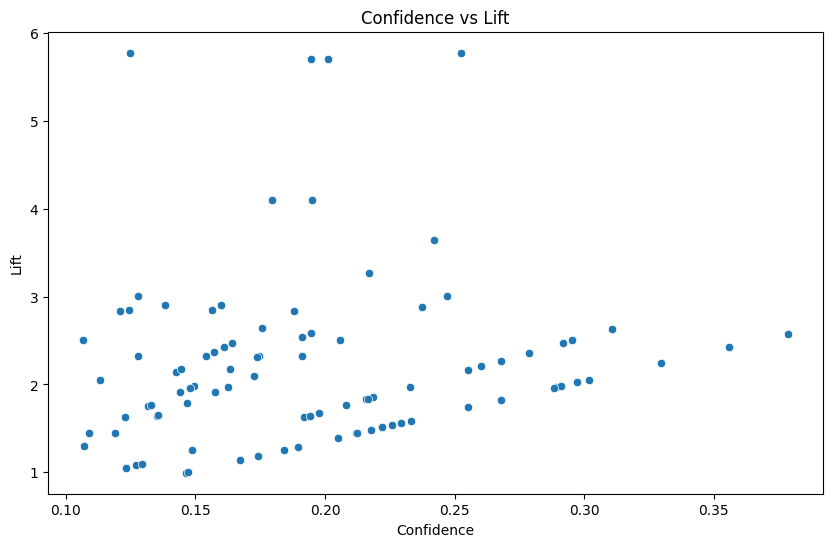

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert association rules to pandas dataframe
association_rules = model.associationRules.toPandas()

plt.figure(figsize=(10,6))
sns.scatterplot(x="confidence", y="lift", data=association_rules)
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.title("Confidence vs Lift")
plt.show()

In [23]:
# Display the top 5 frequent itemsets with 2 or more items
from pyspark.sql.functions import size
model.freqItemsets.filter(size(col("items")) >= 2).sort('freq', ascending=False).show(5, truncate=False)


+----------------------------------------------+-----+
|items                                         |freq |
+----------------------------------------------+-----+
|[Organic Hass Avocado, Bag of Organic Bananas]|62341|
|[Organic Strawberries, Bag of Organic Bananas]|61628|
|[Organic Strawberries, Banana]                |56156|
|[Organic Avocado, Banana]                     |53395|
|[Organic Baby Spinach, Banana]                |51395|
+----------------------------------------------+-----+
only showing top 5 rows



In [27]:
association_rules.sort_values(['lift'], ascending=False)

,antecedent,consequent,confidence,lift,support
39,[Limes],[Organic Cilantro],0.124905,5.775753,0.005464
79,[Organic Cilantro],[Limes],0.252647,5.775753,0.005464
48,[Organic Garlic],[Organic Yellow Onion],0.201069,5.698983,0.006866
87,[Organic Yellow Onion],[Organic Garlic],0.194603,5.698983,0.006866
31,[Large Lemon],[Limes],0.179507,4.103710,0.008524
...,...,...,...,...,...
63,[Organic Avocado],[Bag of Organic Bananas],0.129463,1.096870,0.007120
28,[Large Lemon],[Bag of Organic Bananas],0.127128,1.077088,0.006037
80,[Strawberries],[Bag of Organic Bananas],0.123196,1.043773,0.005478
86,[Organic Yellow Onion],[Banana],0.147188,1.001328,0.005193
